<a href="https://colab.research.google.com/github/sailTo/homework/blob/master/Coupon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Counpon

- Combine offline & online prediction
- transfer learning & Bayesian Network
- linear discriminant analysis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
offline = pd.read_csv('/content/drive/Shareddrives/ubox/ccf_offline_stage1_train.csv')
online = pd.read_csv('/content/drive/Shareddrives/ubox/ccf_online_stage1_train.csv')
offline_test = pd.read_csv('/content/drive/Shareddrives/ubox/ccf_offline_stage1_test_revised.csv')

In [3]:
offline[:5],online[:5]

(   User_id  Merchant_id  Coupon_id  ... Distance  Date_received        Date
 0  1439408         2632        NaN  ...      0.0            NaN  20160217.0
 1  1439408         4663    11002.0  ...      1.0     20160528.0         NaN
 2  1439408         2632     8591.0  ...      0.0     20160217.0         NaN
 3  1439408         2632     1078.0  ...      0.0     20160319.0         NaN
 4  1439408         2632     8591.0  ...      0.0     20160613.0         NaN
 
 [5 rows x 7 columns],
     User_id  Merchant_id  Action  ... Discount_rate Date_received        Date
 0  13740231        18907       2  ...        500:50    20160513.0         NaN
 1  13740231        34805       1  ...           NaN           NaN  20160321.0
 2  14336199        18907       0  ...           NaN           NaN  20160618.0
 3  14336199        18907       0  ...           NaN           NaN  20160618.0
 4  14336199        18907       0  ...           NaN           NaN  20160618.0
 
 [5 rows x 7 columns])

Above is some examples of the offline & online data

In [18]:
from datetime import date
def float_to_mmdd(dataframe):
    d1,d2 = dataframe['Date_received'],dataframe['Date']
    d1,d2 = d1%10000,d2%10000
    dates1 = []
    dates2 = []
    dates3 = []
    for x,y in zip(d1.to_list(),d2.to_list()):
        if x==0:
            dates1.append(x)
            if y==0:
                dates2.append(y)
                dates3.append(-1)
            else:
                date_y = date(2016,int(y//100),int(y%100))
                dates2.append(date_y)
                dates3.append(365)
        elif y==0:
            date_x = date(2016,int(x//100),int(x%100))
            dates1.append(date_x)
            dates2.append(y)
            dates3.append(-365)
        else:
            date_x = date(2016,int(x//100),int(x%100))
            dates1.append(date_x)
            date_y = date(2016,int(y//100),int(y%100))
            dates2.append(date_y)
            dates3.append(abs((date_y-date_x).days))
    dspd1 = pd.DataFrame(data=dates1,columns=['received_date'])
    dspd2 = pd.DataFrame(data=dates2,columns=['used_date'])
    dspd3 = pd.DataFrame(data=dates3,columns=['hold_days'])
    dataframe = dataframe.join(dspd1)
    dataframe = dataframe.join(dspd2)
    dataframe = dataframe.join(dspd3)
    dataframe = dataframe.drop(columns = ['Date_received','Date'])
    return dataframe
online = float_to_mmdd(online.fillna(0))
offline = float_to_mmdd(offline.fillna(0))

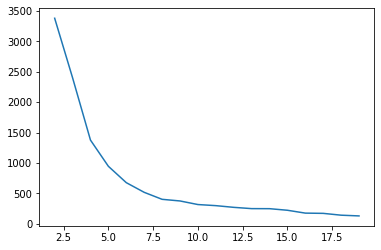

In [18]:
online[(online['hold_days']>=2)&(online['hold_days']<20)]['hold_days'].value_counts().plot()

From here we know that the distribution ofthe hold days is like exponential distribution.

In [19]:
def getWeekday(row):
    if type(row)==type(0.0):
        return row
    else:
        return row.weekday() + 1

online['recieved_weekday'] = online['received_date'].apply(getWeekday)
online['used_weekday'] = online['used_date'].apply(getWeekday)

offline['recieved_weekday'] = offline['received_date'].apply(getWeekday)
offline['used_weekday'] = offline['used_date'].apply(getWeekday)

In [20]:
offline['used_weekday'][(offline['used_weekday']>=1)&(offline['used_weekday']<8)].value_counts()

6.0    117828
5.0    117232
7.0    113983
4.0    109596
3.0    107712
2.0    105472
1.0    105161
Name: used_weekday, dtype: int64

In [16]:
online['recieved_weekday'][(online['recieved_weekday']>=1)&(online['recieved_weekday']<8)].value_counts()

1.0    133537
3.0    129197
2.0    123049
5.0    122775
4.0    122581
6.0    120616
7.0    120602
Name: recieved_weekday, dtype: int64

From here we know that, without considering the difference between the days, the newer coupons always have a greater chance to be used.

In [49]:
print('field:\toffline:\tonline:')
for i in ['User_id','Merchant_id','Coupon_id','Discount_rate']:
    print(i,'\t',online[i].value_counts().shape,'\t',offline[i].value_counts().shape)
for i in ['Date_received','Date']:
    on,off = online[i].unique(),offline[i].unique()
    print('min'+i,min(on[~np.isnan(on)]),min(off[~np.isnan(off)]),sep='\t')
    print('max'+i,max(on[~np.isnan(on)]),max(off[~np.isnan(off)]),sep='\t')
print('total number:',online.shape,'\t',offline.shape)

field:	offline:	online:
User_id 	 (762858,) 	 (539438,)
Merchant_id 	 (7999,) 	 (8415,)
Coupon_id 	 (27747,) 	 (9738,)
Discount_rate 	 (64,) 	 (45,)
minDate_received	20160101.0	20160101.0
maxDate_received	20160615.0	20160615.0
minDate	20160101.0	20160101.0
maxDate	20160630.0	20160630.0
nan nan
total number: (11429826, 7) 	 (1754884, 7)


In [31]:
print('field\tonline\toffline\tsum\tcombine\trepeat_rate')
for i in ['User_id','Merchant_id']:
    n =np.unique(np.concatenate((offline[i].unique(),online[i].unique()),axis = None))
    on,off = online[i].value_counts().shape[0],offline[i].value_counts().shape[0]
    print(i,on,off,on+off,len(n),round(1-len(n)/(on+off),4),sep = '\t')

field	online	offline	sum	combine	repeat_rate
User_id	762858	539438	1302296	1034848	0.2054
Merchant_id	7999	8415	16414	16414	0.0


From here we can know that there are about *20%* users that uses both the online and offline service, while there are not common merchant in the 2 database.

In [64]:
nonna = online[['Date_received','Date']].dropna()
print(nonna['Date']-nonna['Date_received'])
# delta_Date = nonna['Date']-nonna['Date_received']
# delta_Date.value_counts()

519.0
